# Introduccion a la Regresion Logistica con PyTorch

En este cuaderno, vamos a construir una red neuronal muy simple en PyTorch para hacer la clasificación de dígitos escritos a mano.
Primero, empezaremos con una exploración del conjunto de datos MNIST, explicando cómo cargamos y formateamos los datos.
A continuación, pasaremos a motivar y a implementar el modelo de regresión logística, incluyendo el paso hacia delante y hacia atrás, las funciones de pérdida y los optimizadores.
Después de entrenar el modelo, evaluaremos cómo lo hemos hecho y visualizaremos lo que hemos aprendido.
Finalmente, refactorizaremos nuestro código de forma orientada a objetos, utilizando APIs de alto nivel.

Antes de empezar, algunas importaciones de los paquetes que utilizaremos:

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

### MNIST Dataset

El conjunto de datos MNIST es un conjunto de datos de aprendizaje automático muy popular, que consiste en 70000 imágenes en escala de grises de dígitos escritos a mano, de dimensiones 28x28. 
Lo utilizaremos como conjunto de datos de ejemplo para esta sección del tutorial, con el objetivo de predecir qué dígito hay en cada imagen.

![mnist](img/mnist.png)

El primer paso (y a menudo el más importante) en el aprendizaje automático es preparar los datos.
Esto puede incluir descargar, organizar, formatear, barajar, preprocesar, aumentar y agrupar ejemplos para que puedan ser alimentados a un modelo.
El paquete `torchvision` facilita esta tarea implementando muchos de estos elementos, lo que nos permite poner estos conjuntos de datos en un formato utilizable con sólo unas pocas líneas de código.
En primer lugar, vamos a descargar los conjuntos de entrenamiento y prueba de MNIST:

In [4]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

In [6]:
print("Numero de elementos en el set de entrenamiento : {}".format(len(mnist_train)))
print("Numero de elementos en el set de test          : {}".format(len(mnist_test)))

Numero de elementos en el set de entrenamiento : 60000
Numero de elementos en el set de test          : 10000


Como era de esperar, 60000 de los ejemplos MNIST están en el conjunto de entrenamiento, y el resto en el conjunto de prueba.
Añadimos la transformación `ToTensor()` al formatear el conjunto de datos, para convertir los datos de entrada de un tipo de `Imagen` de Pillow en un `Tensor` de PyTorch. Los tensores serán finalmente el tipo de entrada que introduciremos en nuestro modelo. 

Veamos una imagen de ejemplo del conjunto de entrenamiento y su etiqueta.
Fíjate que el tensor `image` es por defecto algo tridimensional.
El "1" en la primera dimensión indica que la imagen sólo tiene un canal (es decir, escala de grises).
Necesitamos deshacernos de esto para visualizar la imagen con `imshow`.

Dimensión original de la imagen: torch.Size([1, 28, 28])
Dimensión Reshapeada de la imagen: torch.Size([28, 28])
La etiqueta de la imagen es: 1


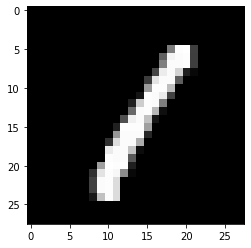

In [7]:
# elejimos una imagen del set de entrenamiento
image, label = mnist_train[3]

# Plot de la imagen
print("Dimensión original de la imagen: {}".format(image.shape))
image = image.reshape([28,28])
print("Dimensión Reshapeada de la imagen: {}".format(image.shape))
plt.imshow(image, cmap="gray")

print("La etiqueta de la imagen es: {}".format(label))

Aunque podríamos trabajar directamente con los datos como un `torchvision.dataset`, nos resultará útil utilizar un `DataLoader`, que se encargará de barajar y agrupar:

In [8]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size = 100, shuffle = True)
test_loader  = torch.utils.data.DataLoader(mnist_test , batch_size = 100, shuffle = False)

Un ejemplo de un minilote extraído de un `DataLoader`:

In [9]:
data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Forma del minilote de imagenes : {}".format(images.shape))
print("Forma del minilote de etiquetas: {}".format(labels.shape))

Forma del minilote de imagenes : torch.Size([100, 1, 28, 28])
Forma del minilote de etiquetas: torch.Size([100])


### Modelo de Regresion Logistica

Ahora que tenemos una buena idea de cómo cargar nuestros datos, vamos a empezar a armar nuestro modelo. 
En este tutorial, vamos a construir un modelo de regresión logística, que es esencialmente una red neuronal totalmente conectada sin ninguna capa oculta. 
Aunque es bastante básica, la regresión logística puede funcionar sorprendentemente bien en muchas tareas de clasificación simples.

#### El paso hacia delante  (forward propagation)

Aunque nuestros datos de entrada (que llamaremos `x`) son imágenes (es decir, bidimensionales), los dígitos de MNIST son bastante pequeños, y el modelo que estamos utilizando es muy simple.
Por lo tanto, vamos a tratar las entradas como vectores planos.
Para convertir nuestras entradas en vectores de fila (es decir, aplanar), podemos utilizar `view()`, el equivalente a `reshape()` de NumPy.
También como en NumPy, podemos reemplazar una de las dimensiones del rediseño con un `-1`, que le dice a PyTorch que infiera esta dimensión basándose en las dimensiones originales y en las otras dimensiones especificadas.
Vamos a probar este aplanamiento en el minibloque de 100 imágenes que dibujamos en la sección anterior.

In [10]:
x = images.view(-1, 28*28)
print("La Forma de entrada x: {}".format(x.shape))

La Forma de entrada x: torch.Size([100, 784])


Para obtener nuestras probabilidades predichas de cada dígito, comencemos primero con la probabilidad de que un dígito sea un 1, como en la imagen anterior. 
Para nuestro modelo simple, podemos empezar aplicando una transformación lineal. 
Es decir, multiplicamos cada píxel $x_i$ del vector de filas de entrada por un peso $w_{i,1}$, los sumamos todos, y luego añadimos un sesgo $b_1$.
Esto es equivalente a un producto punto entre los pesos de la clase "1" y la entrada:

\begin{align}
y_1 = \sum_i x_i w_{i,1} + b_1
\end{align}

La magnitud de este resultado $y_1$, la tomaremos como correlacionada con nuestra creencia en la probabilidad de que el dígito de entrada sea un 1. 
Cuanto mayor sea el valor de $y_1$, más probable es que pensemos que la imagen de entrada $x$ era un 1 (es decir, esperamos obtener un valor relativamente grande para $y_1$ para la imagen anterior). 
Recuerde, sin embargo, que nuestro objetivo original era identificar los 10 dígitos, por lo que en realidad tenemos:

\begin{align*}
y_0 =& \sum_i x_i w_{i,0} + b_0 \\
y_1 =& \sum_i x_i w_{i,1} + b_1 \\
y_2 =& \sum_i x_i w_{i,2} + b_2 \\
y_3 =& \sum_i x_i w_{i,3} + b_3 \\
y_4 =& \sum_i x_i w_{i,4} + b_4 \\
y_5 =& \sum_i x_i w_{i,5} + b_5 \\
y_6 =& \sum_i x_i w_{i,6} + b_6 \\
y_7 =& \sum_i x_i w_{i,7} + b_7 \\
y_8 =& \sum_i x_i w_{i,8} + b_8 \\
y_9 =& \sum_i x_i w_{i,9} + b_9
\end{align*}

Podemos expresarlo en forma de matriz como

\begin{align}
y = x W + b 
\end{align}

Para aprovechar las ventajas del cálculo paralelo, solemos procesar varias entradas $x$ a la vez, en un minilote.
Podemos apilar cada entrada $x$ en una matriz $X$, dándonos 

\begin{align}
Y = X W + b 
\end{align}

Visualización de las dimensiones:

<img src="img/mnist_matmul.PNG" width="500"/>

En nuestro ejemplo concreto, el tamaño del minilote $m$ es de $100$, la dimensión de los datos es de $28 \times 28=784$, y el número de clases $c$ es de 10$.
Aunque $X$ y $Y$ son matrices debido al lote, convencionalmente, se les suele dar nombres de variables en minúscula, como si fueran para un solo ejemplo.
Utilizaremos `x` y `y` en todo momento.

El peso $W$ y el sesgo $b$ constituyen los parámetros de este modelo.
Cuando decimos que queremos "aprender el modelo", lo que realmente intentamos es encontrar buenos valores para cada elemento de $W$ y $b$.
Antes de comenzar el aprendizaje, necesitamos inicializar nuestros parámetros con algún valor, como punto de partida.
En este caso, no sabemos realmente cuáles son los mejores valores, por lo que vamos a inicializar $W$ al azar (utilizando algo llamado [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a.html)), y el set $b$ como un vector de ceros.

In [11]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784) # 
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

Como tanto `W` como `b` son parámetros que queremos aprender, ponemos `requires_grad` a `True`. 
Esto le dice al autograd de PyTorch que rastree los gradientes para estas dos variables, y todas las variables que dependen de `W` y `b`.

Con estos parámetros del modelo, calculamos $y$:

In [12]:
# Transformacion Linear (x . W) + b equivalente a np.dot(x,W) de numpy
y = torch.matmul(x, W) + b

Podemos ver, por ejemplo, el aspecto de las predicciones para el primer ejemplo de nuestro minilote. Recuerda que cuanto mayor sea el número, más cree el modelo que la entrada $x$ es de esa clase.

In [13]:
print(y[0,:])

tensor([ 0.0896,  0.3878,  0.0716, -0.2748, -0.3097, -0.1687,  0.1485,  0.1854,
         0.1702, -0.3884], grad_fn=<SliceBackward>)


Podemos interpretar estos valores (logits) $y$ como probabilidades si los normalizamos para que sean positivos y sumen 1. En la regresión logística, hacemos esto con un softmax:

\begin{align}
p(y_i) = \text{softmax}(y_i) = \frac{\text{exp}(y_i)}{\sum_j\text{exp}(y_j)}
\end{align}

Obsérvese que como el rango de la función exponencial es siempre no negativo, y como estamos normalizando por la suma, el softmax consigue la propiedad deseada de producir valores entre 0 y 1 que suman 1. Si miramos el caso con sólo 2 clases, vemos que el softmax es la extensión multiclase de la función sigmoidea binaria: 

<img src="img/Logistic-curve.png" width="300"/>

Podemos calcular el softmax nosotros mismos usando la fórmula anterior si queremos, pero PyTorch ya tiene la función softmax en `torch.nn.functional`:

In [16]:
F

<module 'torch.nn.functional' from '/home/emi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py'>

In [15]:
# Option 1: Softmax a las probabilidades de la ecuación
py_eq = torch.exp(y) / torch.sum( torch.exp(y) , dim = 1, keepdim = True)
print("py[0] de la ecuación: {}".format(py_eq[0]))

# Option 2: Softmax a probabilidades con torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] conm torch.nn.functional.softmax: {}".format(py[0]))

py[0] de la ecuación: tensor([0.1072, 0.1444, 0.1052, 0.0744, 0.0719, 0.0828, 0.1137, 0.1179, 0.1161,
        0.0664], grad_fn=<SelectBackward>)
py[0] con torch.nn.functional.softmax: tensor([0.1072, 0.1444, 0.1052, 0.0744, 0.0719, 0.0828, 0.1137, 0.1179, 0.1161,
        0.0664], grad_fn=<SelectBackward>)


Ahora hemos definido el paso adelante de nuestro modelo: dada una imagen de entrada, el gráfico devuelve las probabilidades que el modelo piensa que la entrada es cada una de las 10 clases. ¿Hemos terminado?

#### La pérdida de entropía cruzada

Este tutorial aún no ha terminado, así que probablemente puedes adivinar que la respuesta no es del todo. 
Todavía no conocemos los valores de $W$ y $b$. 
¿Recuerdas cómo los inicializamos al azar? 
Antes de ajustar cualquiera de los pesos, necesitamos una manera de medir cómo el modelo está haciendo.
En concreto, vamos a medir lo mal que lo está haciendo el modelo.
Lo hacemos con una función *pérdida*, que toma la predicción del modelo y devuelve un único número (es decir, un escalar) que resume el rendimiento del modelo.
Esta pérdida nos servirá para ajustar los parámetros del modelo.

La pérdida que solemos utilizar en la clasificación es la entropía cruzada, un concepto de la teoría de la información.
Explicar exactamente lo que representa la entropía cruzada va un poco más allá del alcance de este curso, pero se puede pensar en ella como una forma de cuantificar lo lejos que está una distribución $y'$ de otra $y$.

$
\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}
$

En nuestro caso, $y$ es el conjunto de probabilidades predichas por el modelo ($py$ anterior); $y'$ es la distribución objetivo.
¿Qué es la distribución objetivo?
Es la etiqueta verdadera, que es lo que queríamos que el modelo predijera.

La entropía cruzada no sólo capta cuán *correctas* (la máxima probabilidad corresponde a la respuesta correcta) son las respuestas del modelo, sino que también da cuenta de cuán *confiados* (alta confianza en las respuestas correctas) están. Esto anima al modelo a producir probabilidades muy elevadas para las respuestas correctas, al tiempo que reduce las probabilidades de las respuestas erróneas, en lugar de limitarse a conformarse con que sea la argmax. 

Aquí nos centramos en el aprendizaje supervisado, un escenario en el que tenemos las etiquetas.
Nuestro `DataLoader` incluye automáticamente las etiquetas correspondientes a cada una de nuestras entradas.
Aquí están las etiquetas de la primera vez que recuperamos un minilote:

In [17]:
print(labels.shape)

torch.Size([100])


Al igual que la operación softmax, podemos implementar la entropía cruzada directamente desde la ecuación, utilizando la salida de softmax.
Sin embargo, al igual que con el softmax, `torch.nn.functional` ya tiene implementada la pérdida de entropía cruzada también.

In [19]:
labels.shape[0]

100

In [21]:
labels

tensor([9, 4, 0, 3, 3, 0, 5, 4, 8, 0, 1, 3, 8, 5, 4, 6, 3, 9, 7, 0, 0, 3, 8, 5,
        3, 4, 0, 5, 5, 5, 7, 6, 7, 7, 8, 4, 9, 0, 1, 5, 0, 7, 4, 4, 5, 5, 2, 3,
        0, 9, 7, 7, 0, 0, 4, 8, 8, 1, 2, 2, 1, 1, 7, 2, 0, 6, 4, 9, 0, 0, 2, 5,
        2, 6, 5, 0, 8, 1, 4, 2, 5, 9, 8, 2, 8, 9, 5, 3, 9, 4, 7, 0, 8, 8, 7, 8,
        6, 4, 6, 7])

In [21]:
range(labels.shape[0])

range(0, 100)

In [18]:
[range(labels.shape[0]),labels]

[range(0, 100),
 tensor([9, 4, 0, 3, 3, 0, 5, 4, 8, 0, 1, 3, 8, 5, 4, 6, 3, 9, 7, 0, 0, 3, 8, 5,
         3, 4, 0, 5, 5, 5, 7, 6, 7, 7, 8, 4, 9, 0, 1, 5, 0, 7, 4, 4, 5, 5, 2, 3,
         0, 9, 7, 7, 0, 0, 4, 8, 8, 1, 2, 2, 1, 1, 7, 2, 0, 6, 4, 9, 0, 0, 2, 5,
         2, 6, 5, 0, 8, 1, 4, 2, 5, 9, 8, 2, 8, 9, 5, 3, 9, 4, 7, 0, 8, 8, 7, 8,
         6, 4, 6, 7])]

In [48]:
-torch.log(py_eq)[:10,:]

tensor([[2.2335, 1.9353, 2.2515, 2.5979, 2.6328, 2.4918, 2.1746, 2.1377, 2.1529,
         2.7115],
        [2.0614, 2.1527, 2.5657, 2.6426, 2.7236, 2.6272, 2.6907, 1.7451, 2.2532,
         2.0951],
        [1.9087, 2.0111, 2.2343, 2.6846, 2.5376, 2.6855, 2.4747, 2.4774, 2.2222,
         2.1302],
        [2.1101, 2.8551, 2.9220, 2.2419, 2.2914, 3.0545, 2.0426, 1.8335, 2.2264,
         2.1593],
        [2.8000, 2.4107, 3.0182, 1.6985, 3.1380, 2.5291, 2.0408, 2.0631, 1.8720,
         2.4807],
        [2.4922, 2.1636, 2.1196, 2.4452, 2.4557, 2.7276, 2.0078, 2.2613, 1.9463,
         2.7628],
        [2.3001, 2.3423, 2.4422, 2.2383, 2.8368, 2.6285, 2.0998, 1.9007, 1.9643,
         2.7024],
        [2.3497, 1.9428, 2.0845, 2.7129, 2.4659, 2.8253, 2.4283, 1.9268, 2.2133,
         2.4864],
        [2.1921, 2.8320, 2.5315, 1.7389, 2.2742, 2.1586, 2.5043, 2.0974, 2.4359,
         2.7522],
        [2.0797, 2.5650, 2.3346, 2.4501, 2.4905, 2.3361, 2.4484, 1.9535, 2.4140,
         2.1392]], grad_fn=<

In [50]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy de la ecuación                        : {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy con torch.nn.functional.cross_entropy : {}".format(cross_entropy))

cross entropy de la ecuación                        : 2.365664005279541
cross entropy con torch.nn.functional.cross_entropy : 2.3656632900238037


Tenga en cuenta que la pérdida de entropía cruzada de PyTorch combina el operador softmax y la entropía cruzada en una sola operación, por razones de estabilidad numérica.
¡No hagas el softmax dos veces!
Asegúrese de introducir los logits `y` previos al softmax, no las probabilidades `py` posteriores al softmax.

#### The backwards pass

Ahora que tenemos la pérdida como forma de cuantificar lo mal que va el modelo, podemos mejorar nuestro modelo cambiando los parámetros de forma que se minimice la pérdida.
En el caso de las redes neuronales, la forma habitual de hacerlo es con la retropropagación: tomamos el gradiente de la pérdida con respecto a $W$ y $b$ y damos un paso en la dirección que reduce nuestra pérdida.

Si no estuviéramos utilizando un marco de aprendizaje profundo como PyTorch, tendríamos que ir y derivar todos los gradientes nosotros mismos a mano, y luego codificarlos en nuestro programa. 
Ciertamente, aún podríamos hacerlo.
Sin embargo, con las modernas bibliotecas de autodiferenciación, es mucho más rápido y fácil dejar que el ordenador lo haga.

Primero, necesitamos crear un optimizador.
Hay muchas opciones, pero ya que la regresión logística es bastante simple, vamos a utilizar el estándar de descenso de gradiente estocástico (SGD), que hace la siguiente actualización:

\begin{align}
\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}
\end{align}

Donde $\theta$ es un parametro, $\alpha$ es nuestra tasa de aprendizaje (tamaño del paso), y $\nabla_\theta \mathcal{L}$ es el gradiente de nuestra pérdida con respecto a $\theta$.

In [51]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

Cuando creamos nuestros parámetros $W$ y $b$, indicamos que requieren gradientes.
Para calcular los gradientes de $W$ y $b$, llamamos a la función `backward()` sobre la pérdida de entropía cruzada.

In [52]:
cross_entropy.backward()

/home/emi/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Cada una de las variables que requerían gradientes tiene ahora gradientes acumulados.
Podemos verlos por ejemplo en `b`:

In [53]:
b.grad

tensor([-0.0205, -0.0299, -0.0595,  0.0323,  0.0142, -0.0342,  0.0134,  0.0577,
         0.0348, -0.0082])

Para aplicar los gradientes, podríamos actualizar manualmente $W$ y $b$ utilizando la regla de actualización $\theta_{t+1} = \theta_t - \alpha \nabla_\theta \mathcal{L}$, pero como tenemos un optimizador, podemos decirle que realice el paso de actualización por nosotros:

In [54]:
optimizer.step()

Fijamos nuestra tasa de aprendizaje en 0,1, por lo que `b` se ha actualizado en `-0,1*b.grad`:

In [59]:
b

tensor([-0.1160,  0.2018, -0.0314, -0.0892,  0.0717,  0.2946, -0.0253,  0.1614,
        -0.4085, -0.0591], requires_grad=True)

Ya hemos entrenado con éxito un minilote.
Sin embargo, un minilote probablemente no sea suficiente.
En este punto, hemos entrenado el modelo en 100 ejemplos de los 60000 del conjunto de entrenamiento.
Tendremos que repetir este proceso con más datos.

Una cosa más a tener en cuenta: los gradientes calculados por `backward()` no anulan los valores antiguos, sino que se acumulan.
Por lo tanto, querrá borrar los buffers de gradientes antes de calcular los gradientes para el siguiente minilote.

In [60]:
print("b.grad antes zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad despues zero_grad(): {}".format(b.grad))

b.grad antes zero_grad(): tensor([-0.0011, -0.0058, -0.0090,  0.0184, -0.0137, -0.0168,  0.0042,  0.0049,
         0.0089,  0.0100])
b.grad despues zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


#### Model Training

Para entrenar el modelo, sólo tenemos que repetir lo que acabamos de hacer para más minilotes del conjunto de entrenamiento.
Como recapitulación, los pasos fueron
1. Dibujar un mini lote
2. Poner a cero los gradientes en los buffers para `W` y `b`.
3. Realice el pase hacia adelante (compute la predicción, calcule la pérdida)
4. Realizar el paso hacia atrás (calcular los gradientes, realizar el paso SGD)

El paso por todo el conjunto de datos una vez se denomina epoch.
En muchos casos, entrenamos las redes neuronales para múltiples épocas, pero aquí, una sola época es suficiente.
También envolvemos el train_loader con `tqdm`.
Esto no es necesario, pero añade una práctica barra de progreso para que podamos seguir el progreso de nuestro entrenamiento.

In [57]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward pass
    cross_entropy.backward()
    optimizer.step()

  0%|          | 0/600 [00:00<?, ?it/s]

#### Testing

Ahora veamos cómo lo hemos hecho. 
Para cada imagen de nuestro conjunto de pruebas, pasamos los datos por el modelo y tomamos el dígito en el que tenemos la mayor confianza como respuesta. 
A continuación, calculamos la precisión para ver cuántas cifras son correctas.
Vamos a envolver la evaluación con `torch.no_grad()`, ya que no nos interesa calcular gradientes durante la evaluación.
Desactivando el motor de autogradación, podemos acelerar la evaluación.

In [61]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9035000205039978


No está mal para un modelo sencillo y unas pocas líneas de código.
Antes de concluir este ejemplo, hay una cosa más interesante que podemos hacer. 
Normalmente, puede ser difícil inspeccionar exactamente lo que los filtros en un modelo están haciendo, pero ya que este modelo es tan simple, y los pesos transforman los datos directamente a sus logits, podemos realmente visualizar lo que el modelo está aprendiendo simplemente trazando los pesos. 
Los resultados parecen bastante razonables:

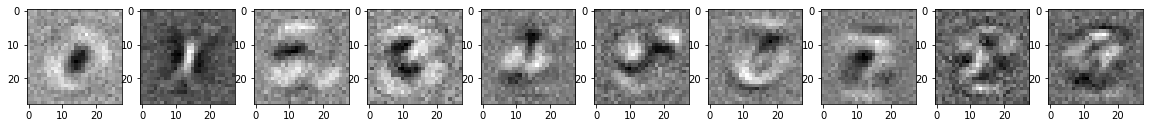

In [62]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

Como podemos ver, el modelo aprendió una plantilla para cada dígito.
Recuerda que nuestro modelo toma un producto de puntos entre los pesos de cada dígito y la entrada.
Por lo tanto, cuanto más coincida la entrada con la plantilla de un dígito, mayor será el valor del producto de puntos para ese dígito, lo que hace que el modelo tenga más probabilidades de predecir ese dígito.

#### The Full Code

Todo el modelo, con la definición completa del modelo, el entrenamiento y la evaluación (pero sin la visualización de los pesos) como código ejecutable de forma independiente:

In [63]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Load the data
mnist_train  = datasets.MNIST(root="./datasets", train = True , transform = transforms.ToTensor(), download = True)
mnist_test   = datasets.MNIST(root="./datasets", train = False, transform = transforms.ToTensor(), download = True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader  = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# inicializar parametros
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)

# Optimizador
optimizer = torch.optim.SGD([W,b], lr=0.1)

# Itera por minibatches 
for images, labels in tqdm(train_loader):
    # Gradientes a cero
    optimizer.zero_grad()
    
    # Forward
    x = images.view(-1, 28*28)
    y = torch.matmul(x, W) + b
    cross_entropy = F.cross_entropy(y, labels)
    # Backward
    cross_entropy.backward()
    optimizer.step()

## Testeo
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9010000228881836


Nota: La exactitud de la versión completa que aparece arriba puede ser ligeramente diferente de la exactitud de la prueba de la versión paso a paso que utilizamos primero. 
Entrenamos nuestro modelo con el descenso de gradiente estocástico (SGD), con la palabra "estocástico" destacando que el entrenamiento es un proceso inherentemente aleatorio.

### Apis de Alto Nivel

Hasta ahora, hemos estado construyendo principalmente redes neuronales con operaciones básicas de PyTorch.
Hemos hecho esto para proporcionar una imagen más clara de cómo los modelos realmente funcionan y lo que está pasando bajo el capó.
Esto puede ser importante a medida que se aprenden los conceptos y los diversos marcos, y a veces el control de bajo nivel es necesario si se está tratando de construir algo nuevo.

Sin embargo, la mayoría de las veces nos encontramos repitiendo las mismas líneas de código bastante estándar, lo que puede ralentizarnos. 
Y lo que es peor, abarrota nuestro código innecesariamente e introduce espacio para los errores y las erratas.
Y por último, como investigadores o ingenieros, nos gustaría pasar la mayor parte de nuestro tiempo pensando en los niveles más altos de abstracción: Quiero añadir una capa de convolución aquí, luego una totalmente conectada allí, etc.
Tener que codificar todos los pequeños detalles son distracciones que pueden restarnos capacidad para traducir las ideas en código.
Por esta razón, PyTorch tiene abstracciones de alto nivel para ayudar a acelerar la implementación y mejorar la organización del modelo.
Aunque hay muchas maneras de organizar el código de PyTorch, un paradigma común es con `torch.nn.Module`.

#### Refactorización orientada a objetos

A menudo tiene sentido que codifiquemos nuestros modelos de una [manera orientada a objetos](https://realpython.com/python3-object-oriented-programming/).
Para entender por qué, volvamos a la transformación lineal $y = xW + b$ que utilizamos para la regresión logística. 
Podemos ver que mientras la operación consistía en una multiplicación de matrices y una suma, también estaba asociada a esta operación la instanciación de dos parámetros `W` y `b`, y estos dos parámetros conceptualmente *pertenecen* a la transformación.
Como tal, tendría sentido agrupar la instanciación de los dos parámetros con la transformación real:

In [64]:
# Note: illustrative example only; see below for torch.nn usage
class xW_plus_b:
    def __init__(self, dim_in, dim_out):
        self.W = torch.randn(dim_in, dim_out)/np.sqrt(dim_in)
        self.W.requires_grad_()
        self.b = torch.zeros(dim_out, requires_grad=True)
        
    def forward(self, x):
        return torch.matmul(x, self.W) + self.b

Para utilizar lo que acabamos de escribir, podemos crear una instancia de `xW_plus_b` utilizando su método `__init__()` (el constructor).
En este caso, vamos a establecer que las dimensiones sean 784 y 10, como hicimos en nuestro ejemplo de regresión logística anterior.
Esto crea una instancia `xW_plus_b` con dos parámetros `W` y `b`.

In [65]:
# Note: illustrative example only; see below for torch.nn usage
lin_custom = xW_plus_b(784, 10)
print("W: {}".format(lin_custom.W.shape))
print("b: {}".format(lin_custom.b.shape))

W: torch.Size([784, 10])
b: torch.Size([10])


Después de instanciar la instancia, podemos realizar la transformación lineal real de nuestra clase personalizada `xW_plus_b` llamando a la función `forward()` de la instancia:

In [66]:
# Note: illustrative example only; see below for torch.nn usage
x_rand = torch.randn(1,784)
y = lin_custom.forward(x_rand)
print(y.shape)

torch.Size([1, 10])


#### Usando  `torch.nn`

Aunque ciertamente podemos implementar nuestras propias clases para las operaciones que nos gustaría utilizar, no tenemos que hacerlo, ya que PyTorch ya las tiene en la sublibrería `torch.nn`. 

In [67]:
import torch.nn as nn

Por ejemplo, el ejemplo de transformación lineal que acabamos de ver se llama `torch.nn.Linear`:

In [69]:
lin = nn.Linear(784, 10)
print("Linear parameters: {}".format([p.shape for p in lin.parameters()]))

y = lin(x_rand)
print(y.shape)

Linear parameters: [torch.Size([10, 784]), torch.Size([10])]
torch.Size([1, 10])


La implementación de `nn.Linear` tiene algunas cosas más bajo el capó (fíjese, por ejemplo, que la función `forward()` se aliasa con la llamada a la propia instancia), pero en espíritu, opera de forma muy parecida a nuestra clase personalizada `xW_plus_b`.
En la primera línea, instanciamos un objeto `Linear`, que crea automáticamente variables de peso y sesgo de las dimensiones especificadas.
La cuarta línea llama a la función `forward()` (con el alias de la llamada al objeto), que realiza la transformación lineal.

#### Usando `torch.nn.Module`

La clase `torch.nn.Linear` que acabamos de ver es una subclase de `torch.nn.Module`.
Sin embargo, los `Módulos` no tienen por qué describir una sola operación; también pueden definir una cadena de operaciones, cada una de las cuales puede ser también un `Módulo`.
Así, podemos colocar toda nuestra red neuronal dentro de un `Módulo`.
En este caso, el módulo puede rastrear todos sus parámetros asociados, algunos de los cuales también pueden estar asociados a un submódulo (por ejemplo, `nn.Linear`), mientras que también define la función `forward()`, en un solo lugar.

In [70]:
class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

En este ejemplo concreto, no hemos necesitado encadenar ninguna operación, pero veremos que esto es muy útil cuando pasemos a modelos más complejos.
Además, el `nn.Module` que subclasificamos tiene algunas otras características interesantes.
Por ejemplo:
- La función `forward()` de un `nn.Module` llamará a la función `forward()` de cualquier `nn.Module` hijo.
- La función `print()` imprimirá un resumen formateado de nuestro modelo, resumiendo también recursivamente cualquier `nn.Module` hijo.
- La función `parameters()` devolverá un generador que devuelve todos los parámetros de un `nn.Module` (incluyendo los de cualquier hijo).

In [71]:
model = MNIST_Logistic_Regression()
y = model(x_rand)
print("The model: \n{}".format(model))
print("\nParameters: \n{}".format(list(model.parameters())))
print("\nOutput shape: \n{}".format(y.shape))

The model: 
MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

Parameters: 
[Parameter containing:
tensor([[-0.0086,  0.0332,  0.0011,  ...,  0.0266, -0.0131, -0.0280],
        [-0.0052, -0.0007,  0.0223,  ...,  0.0103, -0.0140, -0.0342],
        [-0.0137, -0.0271, -0.0347,  ...,  0.0007, -0.0077, -0.0300],
        ...,
        [ 0.0332,  0.0295,  0.0062,  ..., -0.0325, -0.0146, -0.0086],
        [ 0.0102, -0.0107,  0.0240,  ..., -0.0270, -0.0121,  0.0274],
        [ 0.0240,  0.0295, -0.0338,  ..., -0.0053, -0.0117,  0.0274]],
       requires_grad=True), Parameter containing:
tensor([ 0.0080, -0.0342,  0.0154,  0.0323, -0.0034,  0.0355, -0.0168,  0.0282,
        -0.0351,  0.0150], requires_grad=True)]

Output shape: 
torch.Size([1, 10])


#### Full code with `nn.Module`

Refactoring our previous complete logistic regression code to use a `nn.Module`:

In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train  = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test   = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader  = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9035000205039978


Aunque los beneficios de organizar un modelo como un `nn.Module` pueden no ser tan obvios para un simple modelo de regresión logística, este estilo de programación permite implementaciones mucho más rápidas y limpias para modelos más complejos, como veremos en cuadernos posteriores.